# PIP examples

In this notebook we will show how to compute power spectra with PIP weights, with major inspiration from https://arxiv.org/pdf/1703.02070.pdf. The power spectrum estimator with PIP correction is introduced in https://arxiv.org/pdf/1912.08803.pdf.
Look first at notebook basic_examples.ipynb to understand the *pypower* API.

In [1]:
import os
import tempfile
import numpy as np
from scipy import spatial
from matplotlib import pyplot as plt

from pypower import CatalogFFTPower, utils, setup_logging

# To activate logging
setup_logging()

In [16]:
# First, generate fake data with cartesian positions and weights, in a box of size 800 (Mpc/h) at 1000 (Mpc/h).

def generate_catalogs(size=100000, boxsize=(800,)*3, offset=(1000.,0,0), n_individual_weights=1, seed=42):
    rng = np.random.RandomState(seed=seed)
    positions = [o + rng.uniform(-0.5, 0.5, size)*b for o, b in zip(offset, boxsize)]
    weights = [np.ones(size, dtype='f8') for i in range(n_individual_weights)]
    return positions, weights

size = 100000
parent_positions, parent_weights = generate_catalogs(size=size)
randoms_positions, randoms_weights = generate_catalogs(size=10*size, seed=84)

# Three scenarii
- uncorrelated: objects within close pairs are randomly removed. That an object in close pair does not receive a fiber does not impact on the fiber assignment for the other object: selection probabilities of close objects are uncorrelated. There are no zero probability pairs.
- onepass: we randomly pick a close pair and randomly discard one of the two objects; we iterate the procedure until there are no more close pairs. This is the "maximum randomness" algorithm used in https://arxiv.org/pdf/1703.02070.pdf. Selection probabilites of close objects are correlated. There are zero probability pairs.
- twopass: same as singlepass, with an extra pass on objects left without fiber in the first pass. All pairs are non-zero probability with multiple passes.
- twopass-fsky: same as singlepass, with an extra pass on objects left without fiber in the first pass on some fraction of the sky. All pairs are non-zero probability in the region with multiple passes.

In [17]:
# First find all (unique) pairs within 0.08 deg.
def find_collision_pairs(positions, radius_in_degree=0.1):
    distance = sum(p**2 for p in positions)**0.5
    unit_positions = np.array([p/distance for p in positions]).T
    tree = spatial.cKDTree(unit_positions, leafsize=16, compact_nodes=True, copy_data=False, balanced_tree=True)
    radius = 2.*np.sin(np.radians(radius_in_degree) / 2.) # distance on the unit sphere
    pairs = tree.query_pairs(radius, p=2., eps=0, output_type='ndarray')
    return pairs

parent_size = len(parent_positions[0])
target_pairs = find_collision_pairs(parent_positions)
print('Found {:d}/{:d} targets in pairs.'.format(target_pairs.shape[0], parent_size))

Found 66262/100000 targets in pairs.


In [24]:
def run_uncorrelated_fiber_assignment(size, pairs, prob=0.5, nrealizations=65, seed=42):
    # Objects within close pairs are randomly removed with probability prob.
    bits = []
    indices_close_pairs = np.unique(pairs)
    rng = np.random.RandomState(seed=seed)
    for ireal in range(nrealizations):
        #print(ireal, end=" ")
        bit = np.ones(size, dtype='?')
        bit[indices_close_pairs] = rng.uniform(0., 1., indices_close_pairs.size) < prob
        bits.append(bit)
    return bits

def mr_fiber_collisions(rng, size, pairs):
    # We randomly pick a close pair and randomly discard one of the two objects.
    # We iterate the procedure until there are no more close pairs.
    bit = np.ones(size, dtype='?')
    # For speed, treat first isolated pairs
    counts = np.zeros(size, dtype='i4')
    for pair in target_pairs:
        counts[pair[0]] += 1
        counts[pair[1]] += 1
    isolated_pairs, multiple_pairs = [], []
    for pair in target_pairs:
        if counts[pair[0]] <= 1 and counts[pair[1]] <= 1:
            isolated_pairs.append(pair)
        else:
            multiple_pairs.append(pair)
    
    indices = rng.randint(2, size=len(isolated_pairs))
    # Isolated pairs can be treated independently
    for ii,index in enumerate(indices):
        index = isolated_pairs[ii][index]
        bit[index] = 0
    
    # Then, for speed, group pairs into (independent) collision groups
    collision_groups = []
    groupids = -np.ones(size, dtype='i4')
    for pair in multiple_pairs:
        groupid1, groupid2 = groupids[pair[0]], groupids[pair[1]]
        if groupid1 < 0 and groupid2 < 0:
            groupids[pair[0]] = groupids[pair[1]] = len(collision_groups)
            collision_groups.append(set(pair))
        elif groupid1 >= 0 and groupid2 < 0:
            groupids[pair[1]] = groupid1
            collision_groups[groupid1].add(pair[1])
        elif groupid2 >= 0 and groupid1 < 0:
            groupids[pair[0]] = groupid2
            collision_groups[groupid2].add(pair[0])
        elif groupid1 != groupid2:
            for idx in collision_groups[groupid2]:
                groupids[idx] = groupid1
            collision_groups[groupid1] |= collision_groups[groupid2]
            collision_groups[groupid2] = set() # to keep groupids the same
    
    assert sum(len(grp) for grp in collision_groups) == np.unique(multiple_pairs).size # check all objects in collision groups
    
    # We actually want list of pairs for each collision group
    collision_groups_pairs = [[] for ii in range(len(collision_groups))]
    for pair in multiple_pairs:
        assert groupids[pair[0]] == groupids[pair[1]]
        collision_groups_pairs[groupids[pair[0]]].append(pair)
    
    collision_groups_pairs = [grp for grp in collision_groups_pairs if grp]
    
    while len(collision_groups_pairs):
        colgrps = collision_groups_pairs
        collision_groups_pairs = []
        for grp in colgrps:
            index = grp[rng.randint(len(grp))][rng.randint(2)]
            bit[index] = 0
            grp = [pair for pair in grp if index not in pair]
            if grp:
                collision_groups_pairs.append(grp)
    return bit

def run_mr_fiber_assignment(size, pairs, npasses=1, fsky_multiple_pass=1., nrealizations=65, seed=42):
    # Run mr_fiber_collisions with multiple passes.
    # The first pass is run full-sky, the other passes are run on fsky_multiple_pass of the sky.
    indices_multiple_pass = np.arange(int(fsky_multiple_pass * size + 0.5))
    bits = []
    rng = np.random.RandomState(seed=seed)
    for ireal in range(nrealizations):
        #print(ireal, end=" ")
        bit = np.zeros(size, dtype='?')
        n_pairs = target_pairs.shape[0] + 1
        for ipass in range(npasses):
            if ipass == 0:
                indices = np.arange(size)
            else:
                indices = indices_multiple_pass
            collided = np.flatnonzero(~bit[indices])
            _pairs = pairs[np.all(np.isin(pairs, collided), axis=-1)]
            _n_pairs = _pairs.shape[0]
            assert _n_pairs < n_pairs
            n_pairs = _n_pairs
            bit[indices] = mr_fiber_collisions(rng, size, _pairs)[indices]
        bits.append(bit)
    return bits

# getting fiber assignment runs
nrealizations = 65
cases = {}

#cases['uncorrelated'] = {'bits': run_uncorrelated_fiber_assignment(parent_size, target_pairs, nrealizations=nrealizations, prob=0.5, seed=42)}
#cases['onepass'] = {'bits': run_mr_fiber_assignment(parent_size, target_pairs, nrealizations=nrealizations, npasses=1, fsky_multiple_pass=1., seed=42)}
cases['twopass'] = {'bits': run_mr_fiber_assignment(parent_size, target_pairs, nrealizations=nrealizations, npasses=2, fsky_multiple_pass=1., seed=42)}
cases['twopass-fsky'] = {'bits': run_mr_fiber_assignment(parent_size, target_pairs, nrealizations=nrealizations, npasses=2, fsky_multiple_pass=0.5, seed=42)}

for name, case in cases.items():
    this = case['bits'][0]
    fiberassign_bits = utils.pack_bitarrays(*case['bits'][1:], dtype=np.uint64)
    # restricting to the objects that received a fiber in the actual pass
    positions = [p[this] for p in parent_positions]
    weights = [w[this] for w in parent_weights]
    bitwise_weights = [w[this] for w in fiberassign_bits]
    case.update(positions=positions, weights=weights, bitwise_weights=bitwise_weights)

In [25]:
# Routine to run power spectrum estimations with different weighting schemes
def run_case(case, edges, ells=(0, 2, 4), boxsize=1000., nmesh=256, resampler='tsc', interlacing=2, direct_limits=(0., 0.3)):
    positions = case['positions']
    weights = case['weights']
    bitwise_weights = case['bitwise_weights']
    # Parent sample
    result_parent = CatalogFFTPower(data_positions1=parent_positions, data_weights1=parent_weights,
                                    randoms_positions1=randoms_positions, randoms_weights1=randoms_weights,
                                    boxsize=boxsize, nmesh=nmesh, resampler=resampler, interlacing=interlacing,
                                    edges=edges, ells=ells, direct_limits=direct_limits, position_type='xyz').poles

    # No weights
    result_fibered = CatalogFFTPower(data_positions1=positions, data_weights1=weights,
                                    randoms_positions1=randoms_positions, randoms_weights1=randoms_weights,
                                    boxsize=boxsize, nmesh=nmesh, resampler=resampler, interlacing=interlacing,
                                    edges=edges, ells=ells, direct_limits=direct_limits, position_type='xyz').poles
    
    
    # With iip weights (nrealizations already includes current realization)
    wiip = nrealizations/(1 + utils.popcount(*bitwise_weights))
    result_iip = CatalogFFTPower(data_positions1=positions, data_weights1=wiip*weights[0],
                                 randoms_positions1=randoms_positions, randoms_weights1=randoms_weights,
                                 boxsize=boxsize, nmesh=nmesh, resampler=resampler, interlacing=interlacing,
                                 edges=edges, ells=ells, direct_limits=direct_limits, position_type='xyz').poles

    # With pip weights
    result_pip = CatalogFFTPower(data_positions1=positions, data_weights1=bitwise_weights + weights,
                                 randoms_positions1=randoms_positions, randoms_weights1=randoms_weights,
                                 boxsize=boxsize, nmesh=nmesh, resampler=resampler, interlacing=interlacing,
                                 edges=edges, ells=ells, direct_limits=direct_limits, position_type='xyz').poles
    return result_parent, result_fibered, result_iip, result_pip

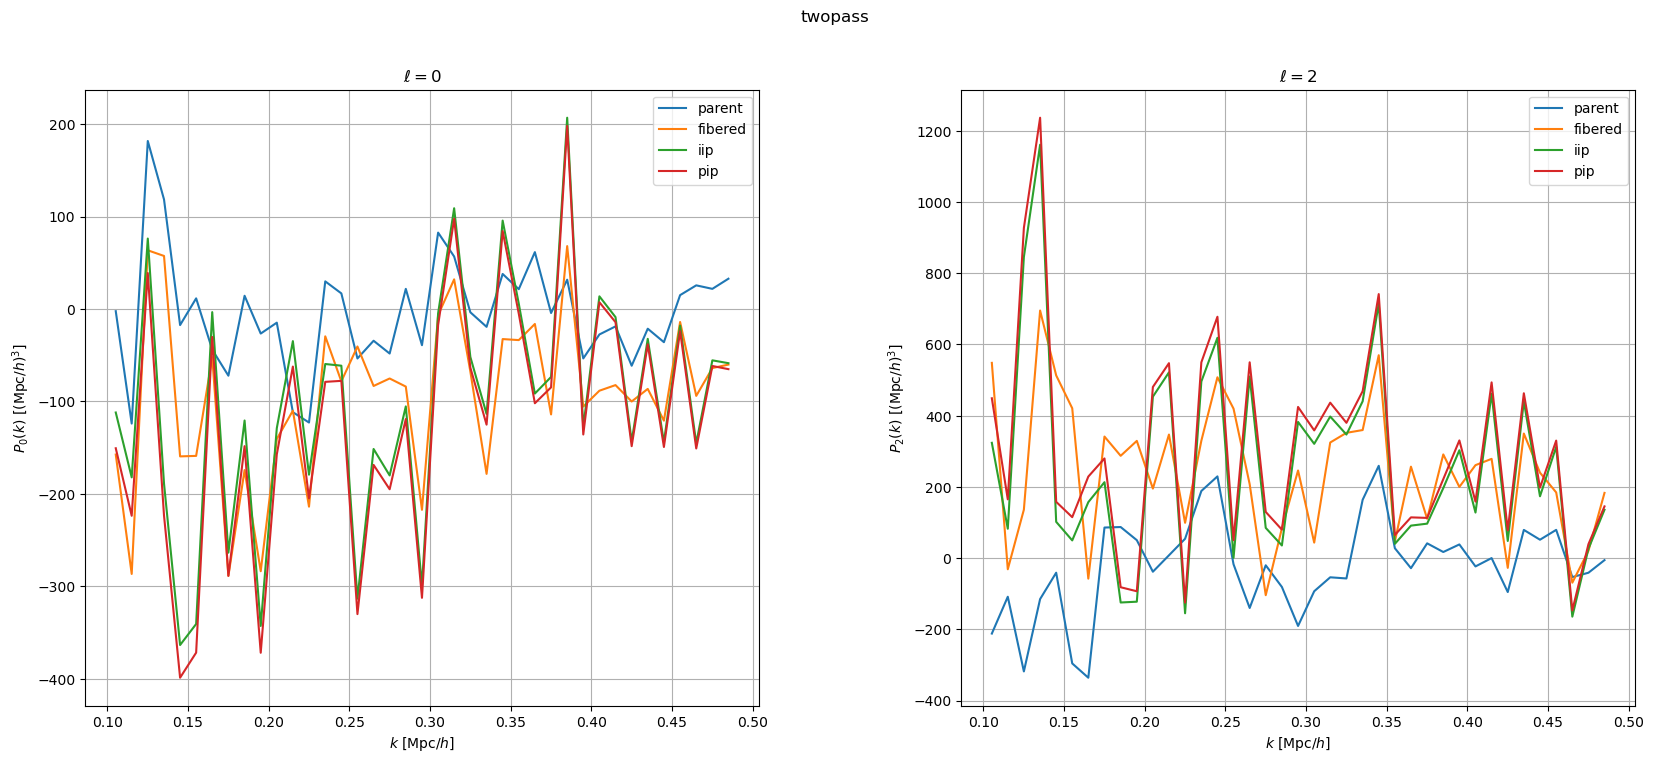

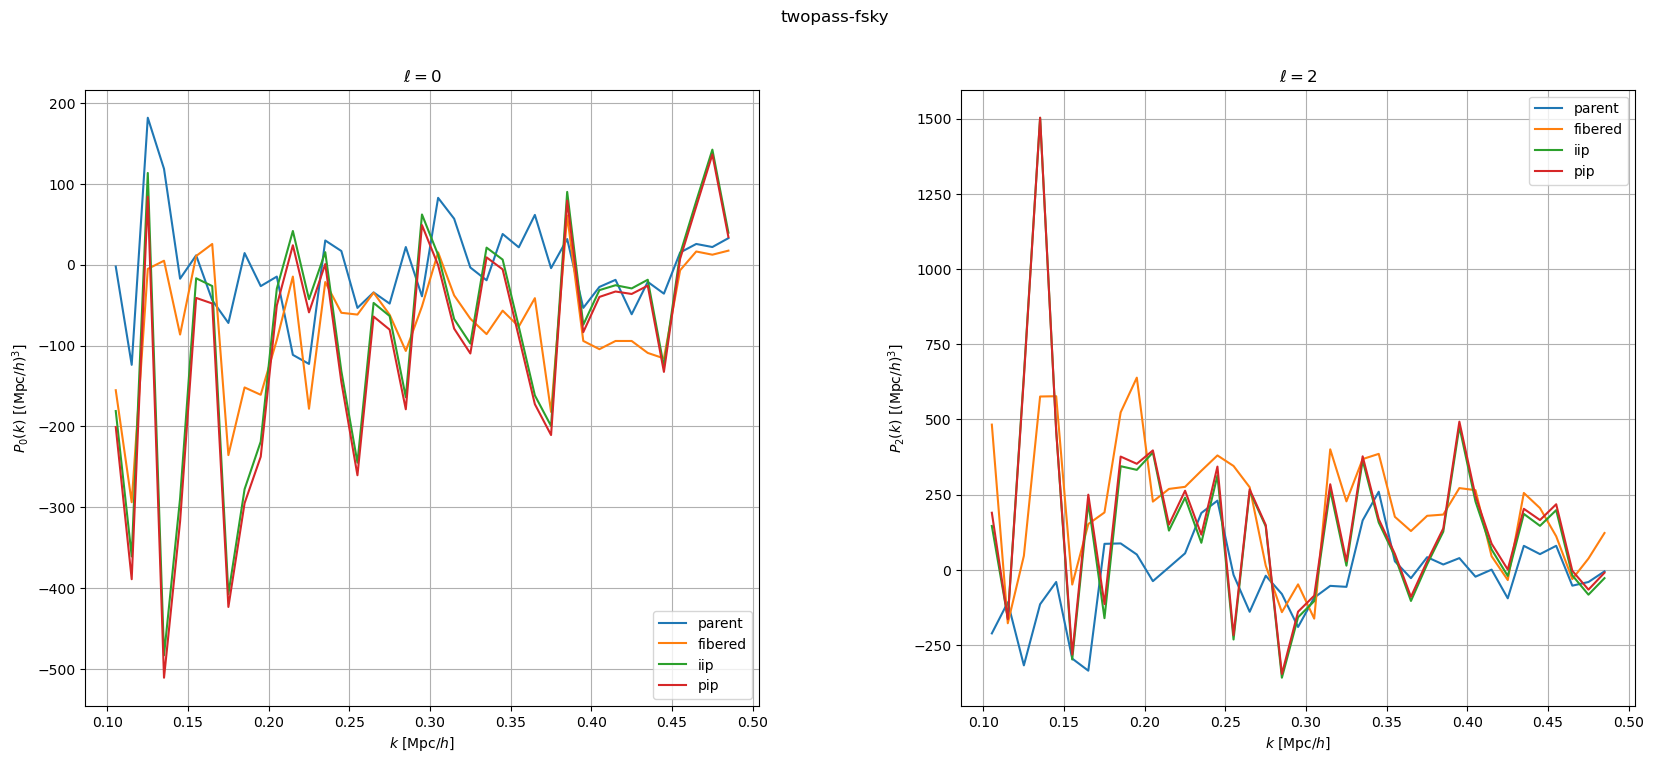

In [26]:
ells = (0, 2)
edges = np.arange(0.1, 0.5, 0.01)

# Deactivate logging as it is a bit wordy
setup_logging('warning')
for name in ['twopass', 'twopass-fsky']:
    
    result_parent, result_fibered, result_iip, result_pip = run_case(cases[name], edges, ells=ells)
    fig, lax = plt.subplots(ncols=len(result_parent.ells), nrows=1, sharex=False, sharey=False, figsize=(20, 8))
    fig.suptitle(name)
    fig.subplots_adjust(hspace=0.4, wspace=0.3)
    lax = lax.flatten()
    for ax, ell in zip(lax, result_parent.ells):
        ax.set_title(r'$\ell = {}$'.format(ell))
        ax.plot(result_parent.k, result_parent(ell=ell).real, label='parent')
        ax.plot(result_fibered.k, result_fibered(ell=ell).real, label='fibered')
        ax.plot(result_iip.k, result_iip(ell=ell).real, label='iip')
        ax.plot(result_pip.k, result_pip(ell=ell).real, label='pip')
        ax.set_xlabel('$k$ [$\mathrm{Mpc}/h$]')
        ax.set_ylabel(r'$P_{:d}(k)$ [$(\mathrm{{Mpc}}/h)^{{3}}$]'.format(ell))
        ax.grid(True)
        ax.legend()

plt.show()

### The different curves
- The "parent" curve corresponds to the power spectrum multipoles of the initial target or "unfibered" sample. This curve is zero as input positions are uniformly random.
- The "fibered" curve corresponds to the power spectrum multipoles of the "fibered" sample, i.e. the sample of objects that received a fiber.
- The "iip" curve corresponds to the power spectrum multipoles of the fibered sample with individual inverse weights defined by wiip = nrealizations/(1 + popcount(bitwise_weight)), which ignores correlation in selection probabilites of close objects ("popcount" counts the number of 1 bits, i.e. returns the number of fiber assignment realizations where this object was selected).
- The "pip" curve corresponds to the the power spectrum multipoles of the fibered sample with pairwise inverse probability pairs defined for a *pair* of objects by wpip = nrealisations/(1 + popcount(bitwise_weight1 & bitwise_weight2)) (here "popcount" counts the number of fiber assignment realizations where this *pair* was selected). In practice, the power spectrum estimation is split as the sum of the power spectrum multipoles estimated with wiip on a mesh, and the contribution wpip12 - wiip1 * wiip2, which contributes only below the selection-correlation length, is computed via direct summation.

### The different plots (cases)
- In the "uncorrelated" case, selection probabilities of close objects are uncorrelated. Hence the power spectrum is fully corrected by IIP weights. PIP weights are statistically equivalent to IIP weights in this case.
- In the "onepass" case, selection probabilities of close objects are correlated. Hence PIP weights are required. Yet we see no weighting scheme can recover an unbiased estimate of the power spectrum. This is because all pairs are zero-probability: what we want to avoid in a real survey.
- In the "twopass" case, fiber assignment is run twice. Hence there are no zero-probability pairs. We see that PIP weights are required (IIP weights are not sufficient), because selection probabilities of close objects are correlated.
- In the "twopass-fsky" case, fiber assignment is twice only one 50% of the footprint. There are zero-probability pairs.